In [1322]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf
import  matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib


In [1323]:
df = pd.read_csv("../BTC_1_year_data_15m.csv").set_index("close_time")
print(df.head())

                                      open      high       low     close  \
close_time                                                                 
2024-12-02 12:44:59.999000+00:00  95386.14  95407.64  95080.85  95080.86   
2024-12-02 12:59:59.999000+00:00  95080.85  95087.98  94766.00  94972.02   
2024-12-02 13:14:59.999000+00:00  94972.03  95490.37  94837.77  95399.83   
2024-12-02 13:29:59.999000+00:00  95399.84  95743.66  95397.31  95690.65   
2024-12-02 13:44:59.999000+00:00  95690.64  95822.61  95567.44  95577.74   

                                     volume                  open_time  \
close_time                                                               
2024-12-02 12:44:59.999000+00:00  299.14374  2024-12-02 12:30:00+00:00   
2024-12-02 12:59:59.999000+00:00  352.27560  2024-12-02 12:45:00+00:00   
2024-12-02 13:14:59.999000+00:00  389.06173  2024-12-02 13:00:00+00:00   
2024-12-02 13:29:59.999000+00:00  478.14614  2024-12-02 13:15:00+00:00   
2024-12-02 13:44:59.999

#### Feature Engineering

In [1324]:
df['close_log_return'] = np.log(df['close'] / df['close'].shift(1))
df

,open,high,low,close,volume,open_time,taker_buy_base,close_log_return
close_time,,,,,,,,
2024-12-02 12:44:59.999000+00:00,95386.14,95407.64,95080.85,95080.86,299.14374,2024-12-02 12:30:00+00:00,110.43173,NaN
2024-12-02 12:59:59.999000+00:00,95080.85,95087.98,94766.00,94972.02,352.27560,2024-12-02 12:45:00+00:00,139.92863,-0.001145
2024-12-02 13:14:59.999000+00:00,94972.03,95490.37,94837.77,95399.83,389.06173,2024-12-02 13:00:00+00:00,213.37077,0.004494
2024-12-02 13:29:59.999000+00:00,95399.84,95743.66,95397.31,95690.65,478.14614,2024-12-02 13:15:00+00:00,272.74969,0.003044
2024-12-02 13:44:59.999000+00:00,95690.64,95822.61,95567.44,95577.74,445.23818,2024-12-02 13:30:00+00:00,222.18680,-0.001181
...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,87084.00,87419.99,86993.27,87419.99,239.49429,2025-12-02 11:15:00+00:00,145.59817,0.003851
2025-12-02 11:44:59.999000+00:00,87419.99,87458.67,87320.01,87329.60,223.03098,2025-12-02 11:30:00+00:00,140.45822,-0.001035
2025-12-02 11:59:59.999000+00:00,87329.60,87602.47,87326.85,87368.92,146.36004,2025-12-02 11:45:00+00:00,93.61402,0.000450


    Create lagged features

In [1325]:
df = df.copy()

In [1326]:
df["close_log_return_lag_1"] = df["close_log_return"].shift()
df["close_log_return_lag_2"] = df["close_log_return"].shift(2)
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)

In [1327]:
df[["close_log_return","close_log_return_lag_1","close_log_return_lag_2","close_log_return_lag_3"]]

,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
close_time,,,,
2024-12-02 12:44:59.999000+00:00,NaN,NaN,NaN,NaN
2024-12-02 12:59:59.999000+00:00,-0.001145,NaN,NaN,NaN
2024-12-02 13:14:59.999000+00:00,0.004494,-0.001145,NaN,NaN
2024-12-02 13:29:59.999000+00:00,0.003044,0.004494,-0.001145,NaN
2024-12-02 13:44:59.999000+00:00,-0.001181,0.003044,0.004494,-0.001145
...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,0.003851,-0.002162,0.002398,0.003057
2025-12-02 11:44:59.999000+00:00,-0.001035,0.003851,-0.002162,0.002398
2025-12-02 11:59:59.999000+00:00,0.000450,-0.001035,0.003851,-0.002162


##### Creating Microstructure Features

In [1328]:
df["sell_volume"] = df["volume"] - df["taker_buy_base"]

df["buy_sell_pressure"] = (df["taker_buy_base"] - df["sell_volume"]) / df["volume"]
df["buy_sell_pressure_lag1"] = df["buy_sell_pressure"].shift(1)


In [1329]:
# fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(df["buy_sell_pressure"], label="buy_sell_pressure")
# ax.plot(df["sell_volume"], label="sell_volume")
# ax.plot(df["taker_buy_base"], label="taker_buy_base")
# ax.legend()
# plt.show()


In [1330]:
df = df.dropna(how="any")

    Create binary classification target
        - 1=> Long => Price moves up
        - 0=> Short => Price goes down

In [1331]:
df = df.copy()

In [1332]:
df["close_log_return_dir"] = df["close_log_return"].map(lambda x:1 if x>0 else 0)

In [1333]:
df

,open,high,low,close,volume,open_time,taker_buy_base,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure,buy_sell_pressure_lag1,close_log_return_dir
close_time,,,,,,,,,,,,,,,
2024-12-02 13:44:59.999000+00:00,95690.64,95822.61,95567.44,95577.74,445.23818,2024-12-02 13:30:00+00:00,222.18680,-0.001181,0.003044,0.004494,-0.001145,223.05138,-0.001942,0.140863,0
2024-12-02 13:59:59.999000+00:00,95577.75,95772.27,95482.20,95679.99,323.84653,2024-12-02 13:45:00+00:00,121.63038,0.001069,-0.001181,0.003044,0.004494,202.21615,-0.248839,-0.001942,1
2024-12-02 14:14:59.999000+00:00,95679.99,95787.64,95534.10,95581.31,230.43159,2024-12-02 14:00:00+00:00,103.73757,-0.001032,0.001069,-0.001181,0.003044,126.69402,-0.099624,-0.248839,0
2024-12-02 14:29:59.999000+00:00,95581.31,95920.00,95501.00,95898.26,220.19851,2024-12-02 14:15:00+00:00,134.09355,0.003311,-0.001032,0.001069,-0.001181,86.10496,0.217933,-0.099624,1
2024-12-02 14:44:59.999000+00:00,95898.26,96777.00,95898.26,96718.02,883.17571,2024-12-02 14:30:00+00:00,501.03982,0.008512,0.003311,-0.001032,0.001069,382.13589,0.134632,0.217933,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,87084.00,87419.99,86993.27,87419.99,239.49429,2025-12-02 11:15:00+00:00,145.59817,0.003851,-0.002162,0.002398,0.003057,93.89612,0.215880,-0.127475,1
2025-12-02 11:44:59.999000+00:00,87419.99,87458.67,87320.01,87329.60,223.03098,2025-12-02 11:30:00+00:00,140.45822,-0.001035,0.003851,-0.002162,0.002398,82.57276,0.259540,0.215880,0
2025-12-02 11:59:59.999000+00:00,87329.60,87602.47,87326.85,87368.92,146.36004,2025-12-02 11:45:00+00:00,93.61402,0.000450,-0.001035,0.003851,-0.002162,52.74602,0.279229,0.259540,1


In [1334]:
df_temp = pd.DataFrame(columns=["close_log_return", "close"])
df_temp[["close_log_return", "close"]] = df[["close_log_return", "close"]]

In [1335]:
df = df.drop(columns=["volume", "close_log_return", "open", "high", "low", "close", 'buy_sell_pressure',"taker_buy_base","open_time"])

In [1336]:
def plot_feature_scatter(df, sample_size=2000):
    """
    Creates a scatter plot matrix (pairplot) for all features in df.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing numerical features.
    sample_size : int
        Optional sampling to speed up plotting (very important for large datasets).
    """
    
    # Use only numeric columns
    numeric_df = df.select_dtypes(include=["number"]).copy()

    # Optional sampling for speed
    if len(numeric_df) > sample_size:
        numeric_df = numeric_df.sample(sample_size, random_state=42)

    sns.pairplot(numeric_df, diag_kind="kde")
    plt.show()


In [1337]:
# plot_feature_scatter(df)


    Check class imbalance

In [1338]:
print(df["close_log_return_dir"].value_counts())

close_log_return_dir
0    17561
1    17475
Name: count, dtype: int64


#### Split data into training and testing set but in temporal order

    Feature-Target Split

In [1339]:
X = df.iloc[:,:-1 ]
y = df.iloc[:,-1]

In [1340]:
test_size = 0.2

In [1341]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=test_size, shuffle=False)

In [1342]:
df_temp["close_log_return"]

close_time
2024-12-02 13:44:59.999000+00:00   -0.001181
2024-12-02 13:59:59.999000+00:00    0.001069
2024-12-02 14:14:59.999000+00:00   -0.001032
2024-12-02 14:29:59.999000+00:00    0.003311
2024-12-02 14:44:59.999000+00:00    0.008512
                                      ...   
2025-12-02 11:29:59.999000+00:00    0.003851
2025-12-02 11:44:59.999000+00:00   -0.001035
2025-12-02 11:59:59.999000+00:00    0.000450
2025-12-02 12:14:59.999000+00:00    0.000909
2025-12-02 12:29:59.999000+00:00   -0.000844
Name: close_log_return, Length: 35036, dtype: float64

In [1343]:
def time_split(x, train_size=0.8):
    i = int(len(x) * train_size)
    return x[:i].copy(), x[i:].copy()


df_train_temp, df_test_temp = time_split(df_temp, train_size=0.8)

In [1344]:
print(y_train.value_counts())
print(y_test.value_counts())

close_log_return_dir
0    14031
1    13997
Name: count, dtype: int64
close_log_return_dir
0    3530
1    3478
Name: count, dtype: int64


### Scikit-learn Logistic Regression

In [1345]:
X_train.columns

Index(['close_log_return_lag_1', 'close_log_return_lag_2',
       'close_log_return_lag_3', 'sell_volume', 'buy_sell_pressure_lag1'],
      dtype='object')

In [1346]:
model = LogisticRegression(max_iter=200)

In [1347]:
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [1348]:
accuracy_score(y_train, model.predict(X_train))

0.5477379763094049

In [1349]:
accuracy_score(y_test, model.predict(X_test))


0.5606449771689498

In [1350]:
cm = confusion_matrix(y_test, model.predict(X_test))

<p style="color: yellow">TP, FP, TN, FN are purely relative to whatever you declare as the positive class.</p>

    - 1 is UP prediction
    - 0 is DOWN prediction
    - 1 is positive class
    - 0 is negative class



In [1351]:
TN = cm[0][0]   #True Down  - When it should be down and model predicted down
FN = cm[1][0]   #False down - When it should be up but the model predicted down
FP = cm[0][1]   #False up   - When it should be down but the model predicted up
TP = cm[1][1]   #True UP    - When it should be up and the model predicted up

In [1352]:
print(TN), print(TP), print(FN), print(FN)

1667
2262
1216
1216


(None, None, None, None)

#### Evaluate win rate

    Accuracy Measure

In [1353]:
(TP+TN)/(TP+TN+FP+FN) 

np.float64(0.5606449771689498)

#### Evaluate the up Predictibility

In [1354]:
TP/(TP+FP)

np.float64(0.5483636363636364)

<p style="color: yellow; font-size: 20px">Recall</p>
    


In [1355]:
TP/(TP+FN)  # Here we are essentially looking at - from all the True classes, how many True classes I predicted correctly

np.float64(0.6503737780333525)

<p style="color: yellow; font-size: 20px">Precision</p>

Precision is, for all of my predictions for a particular class, how many times I was right


In [1356]:
TP/(TP+FP) # From all the times I predicted True/UP, How many were actually true/up

np.float64(0.5483636363636364)

#### Evaluate down predictability

<p style="color: yellow; font-size: 20px">Recall</p>


In [1357]:
TN / (TN+FP) # Here we are essentially looking at - from all the False classes, how many false classes I predicted correctly

np.float64(0.47223796033994336)

<p style="color: yellow; font-size: 20px">Precision</p>


In [1358]:
TN / (TN+FN)    # From as many times I predicted false, how many were actually false.

np.float64(0.5782171349288935)

###### **PRECISION**
###### "When I predict UP, how often am I actually right?"

```python
Precision = TP / (TP + FP)
```

**Out of all my UP predictions, how many were actually correct?**

- **Focus:** My predicted UP events (my actions)
- **Fear:** False Positives (wrongly predicting UP when it's actually DOWN)
- **High precision = When I say UP, you can trust me — but I might be missing opportunities**

---

###### **RECALL**
###### "How many actual UP moves did I successfully catch?"

```python
Recall = TP / (TP + FN)
```

**Out of all the real UP days, how many did my model correctly predict as UP?**

- **Focus:** The actual UP events (reality)
- **Fear:** False Negatives (missing UP days)
- **High recall = I catch most of the UP moves, even if I sometimes make wrong predictions**

---

###### **The Key Difference**

| | Precision | Recall |
|---|-----------|--------|
| **Perspective** | YOUR predictions | REALITY's events |
| **Denominator** | What YOU predicted | What ACTUALLY happened |
| **Question** | "Am I accurate?" | "Am I thorough?" |
| **Trading analogy** | "Hit rate of my signals" | "% of opportunities captured" |

---

###### **Trading Strategy Examples**

###### **High Precision, Low Recall Strategy**
- Very selective, only trades slam-dunk setups
- Few trades, but most are winners
- Good for: High transaction costs, limited capital, risk-averse

###### **Low Precision, High Recall Strategy**
- Casts a wide net, takes many signals
- Catches most moves, but many false alarms
- Good for: Low transaction costs, diversification, systematic execution

###### **Balanced Strategy**
- Optimizes F1-score (harmonic mean of precision and recall)
- Trades off some accuracy for better coverage
- Good for: Most real-world trading applications

---

###### **The Trade-off**

You can't maximize both simultaneously:

- ↑ Threshold → ↑ Precision, ↓ Recall (be picky)
- ↓ Threshold → ↓ Precision, ↑ Recall (be aggressive)

**The optimal balance depends on your strategy's economics.**


#### Directional Balance : Short Ratio

In [1359]:
short_ratio = (FN+TN)/(FN+TN+FP+FP)
short_ratio

np.float64(0.43622333182024514)

#### Directional Balance: Long Ratio

In [1360]:
long_ratio = (FP+TP)/(FN+TN+FP+FP)
long_ratio

np.float64(0.6241488878801634)

#### Directional Imbalance

In [1361]:
short_ratio/long_ratio

np.float64(0.6989090909090909)

#### Evaluating Model's profitabilty (Out-of-sample)

In [1362]:
df_test = X_test.copy()

In [1363]:
df_test

,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1
close_time,,,,,
2025-09-20 12:44:59.999000+00:00,-0.000803,0.000188,0.000672,14.52289,-0.682421
2025-09-20 12:59:59.999000+00:00,0.000187,-0.000803,0.000188,10.46479,-0.180839
2025-09-20 13:14:59.999000+00:00,0.000259,0.000187,-0.000803,21.89774,0.246061
2025-09-20 13:29:59.999000+00:00,0.000142,0.000259,0.000187,6.38201,-0.252341
2025-09-20 13:44:59.999000+00:00,0.000129,0.000142,0.000259,15.97457,0.476650
...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,-0.002162,0.002398,0.003057,93.89612,-0.127475
2025-12-02 11:44:59.999000+00:00,0.003851,-0.002162,0.002398,82.57276,0.215880
2025-12-02 11:59:59.999000+00:00,-0.001035,0.003851,-0.002162,52.74602,0.259540


In [1364]:
model.predict(X_test)

array([1, 1, 1, ..., 0, 0, 0], shape=(7008,))

In [1365]:
model.predict_proba(X_test)

array([[0.42331652, 0.57668348],
       [0.4580132 , 0.5419868 ],
       [0.4923722 , 0.5076278 ],
       ...,
       [0.50265936, 0.49734064],
       [0.50410632, 0.49589368],
       [0.51462606, 0.48537394]], shape=(7008, 2))

In [1366]:
df_test["y_pred_binary"] = model.predict(X_test)
df_test[["close_log_return", "close"]] = df_test_temp[["close_log_return", "close"]]

In [1367]:
df_test

,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1,y_pred_binary,close_log_return,close
close_time,,,,,,,,
2025-09-20 12:44:59.999000+00:00,-0.000803,0.000188,0.000672,14.52289,-0.682421,1,0.000187,115844.46
2025-09-20 12:59:59.999000+00:00,0.000187,-0.000803,0.000188,10.46479,-0.180839,1,0.000259,115874.49
2025-09-20 13:14:59.999000+00:00,0.000259,0.000187,-0.000803,21.89774,0.246061,1,0.000142,115890.95
2025-09-20 13:29:59.999000+00:00,0.000142,0.000259,0.000187,6.38201,-0.252341,1,0.000129,115905.93
2025-09-20 13:44:59.999000+00:00,0.000129,0.000142,0.000259,15.97457,0.476650,0,0.000174,115926.11
...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,-0.002162,0.002398,0.003057,93.89612,-0.127475,1,0.003851,87419.99
2025-12-02 11:44:59.999000+00:00,0.003851,-0.002162,0.002398,82.57276,0.215880,0,-0.001035,87329.60
2025-12-02 11:59:59.999000+00:00,-0.001035,0.003851,-0.002162,52.74602,0.259540,0,0.000450,87368.92


#### Add Directional Signal

In [1368]:
df_test["dir_signal"] = np.where(
    df_test["y_pred_binary"] == 1, 1, -1
)  # We have just replaced the zeroes with -1
df_test[["close_log_return", "y_pred_binary", "dir_signal"]]

,close_log_return,y_pred_binary,dir_signal
close_time,,,
2025-09-20 12:44:59.999000+00:00,0.000187,1,1
2025-09-20 12:59:59.999000+00:00,0.000259,1,1
2025-09-20 13:14:59.999000+00:00,0.000142,1,1
2025-09-20 13:29:59.999000+00:00,0.000129,1,1
2025-09-20 13:44:59.999000+00:00,0.000174,0,-1
...,...,...,...
2025-12-02 11:29:59.999000+00:00,0.003851,1,1
2025-12-02 11:44:59.999000+00:00,-0.001035,0,-1
2025-12-02 11:59:59.999000+00:00,0.000450,0,-1


In [1369]:

# Identify when signal actually changes (actual trades)
df_test["signal_change"] = df_test["dir_signal"].diff().fillna(0)
df_test["trade_occurred"] = (df_test["signal_change"] != 0).astype(int)

# Calculate gross returns
df_test["trade_log_return"] = df_test["dir_signal"] * df_test["close_log_return"]
df_test["trade_simple_return"] = np.exp(df_test["trade_log_return"]) - 1

# Apply transaction cost ONLY on trades
transaction_cost = 0.00075  # 0.1%
df_test["trade_cost"] = df_test["trade_occurred"] * transaction_cost

# Net return after costs
df_test["trade_simple_return_net"] = df_test["trade_simple_return"] - df_test["trade_cost"]

# PnL calculation
df_test["trade_pnl"] = 100 * df_test["trade_simple_return_net"]
df_test["cumulative_pnl"] = df_test["trade_pnl"].cumsum()

# Diagnostic
print(f"Total bars: {len(df_test)}")
print(f"Actual trades: {df_test['trade_occurred'].sum()}")
print(f"Total transaction costs: ${df_test['trade_cost'].sum() * 100:.2f}")

Total bars: 7008
Actual trades: 2337
Total transaction costs: $175.28


In [1370]:
# What's the gross cumulative PnL?
df_test["gross_pnl"] = 100 * df_test["trade_simple_return"]
print(f"Gross final PnL: ${df_test['gross_pnl'].sum():.2f}")

# What's the net cumulative PnL?
print(f"Net final PnL: ${df_test['trade_pnl'].sum():.2f}")

# Difference should equal transaction costs
print(f"Difference: ${df_test['gross_pnl'].sum() - df_test['trade_pnl'].sum():.2f}")

Gross final PnL: $231.41
Net final PnL: $56.14
Difference: $175.27


#### Add trade log return

In [1371]:
df_test["trade_log_return"] = df_test["dir_signal"] * df_test["close_log_return"]
df_test[
    [
        "close_log_return",
        "y_pred_binary",
        "dir_signal",
        "trade_log_return",
    ]
]

,close_log_return,y_pred_binary,dir_signal,trade_log_return
close_time,,,,
2025-09-20 12:44:59.999000+00:00,0.000187,1,1,0.000187
2025-09-20 12:59:59.999000+00:00,0.000259,1,1,0.000259
2025-09-20 13:14:59.999000+00:00,0.000142,1,1,0.000142
2025-09-20 13:29:59.999000+00:00,0.000129,1,1,0.000129
2025-09-20 13:44:59.999000+00:00,0.000174,0,-1,-0.000174
...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,0.003851,1,1,0.003851
2025-12-02 11:44:59.999000+00:00,-0.001035,0,-1,0.001035
2025-12-02 11:59:59.999000+00:00,0.000450,0,-1,-0.000450


#### Compound growth returns (Log returns are time additive)

In [1372]:
df_test["cum_trade_log_return"] = df_test["trade_log_return"].cumsum()

In [1373]:
df_test["cum_trade_log_return"]

close_time
2025-09-20 12:44:59.999000+00:00    0.000187
2025-09-20 12:59:59.999000+00:00    0.000446
2025-09-20 13:14:59.999000+00:00    0.000588
2025-09-20 13:29:59.999000+00:00    0.000717
2025-09-20 13:44:59.999000+00:00    0.000543
                                      ...   
2025-12-02 11:29:59.999000+00:00    2.291809
2025-12-02 11:44:59.999000+00:00    2.292844
2025-12-02 11:59:59.999000+00:00    2.292394
2025-12-02 12:14:59.999000+00:00    2.291484
2025-12-02 12:29:59.999000+00:00    2.292328
Name: cum_trade_log_return, Length: 7008, dtype: float64

<Axes: xlabel='close_time'>

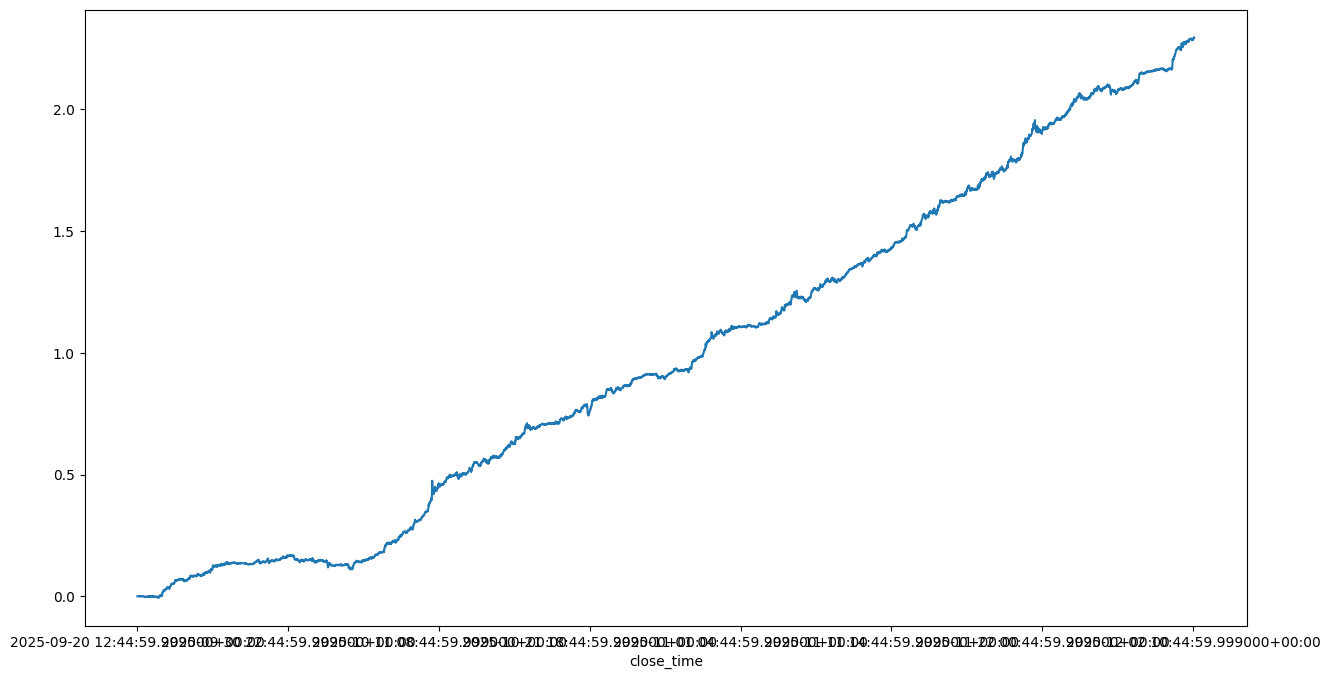

In [1374]:
df_test["cum_trade_log_return"].plot(figsize=(15, 8))

<Axes: xlabel='close_time'>

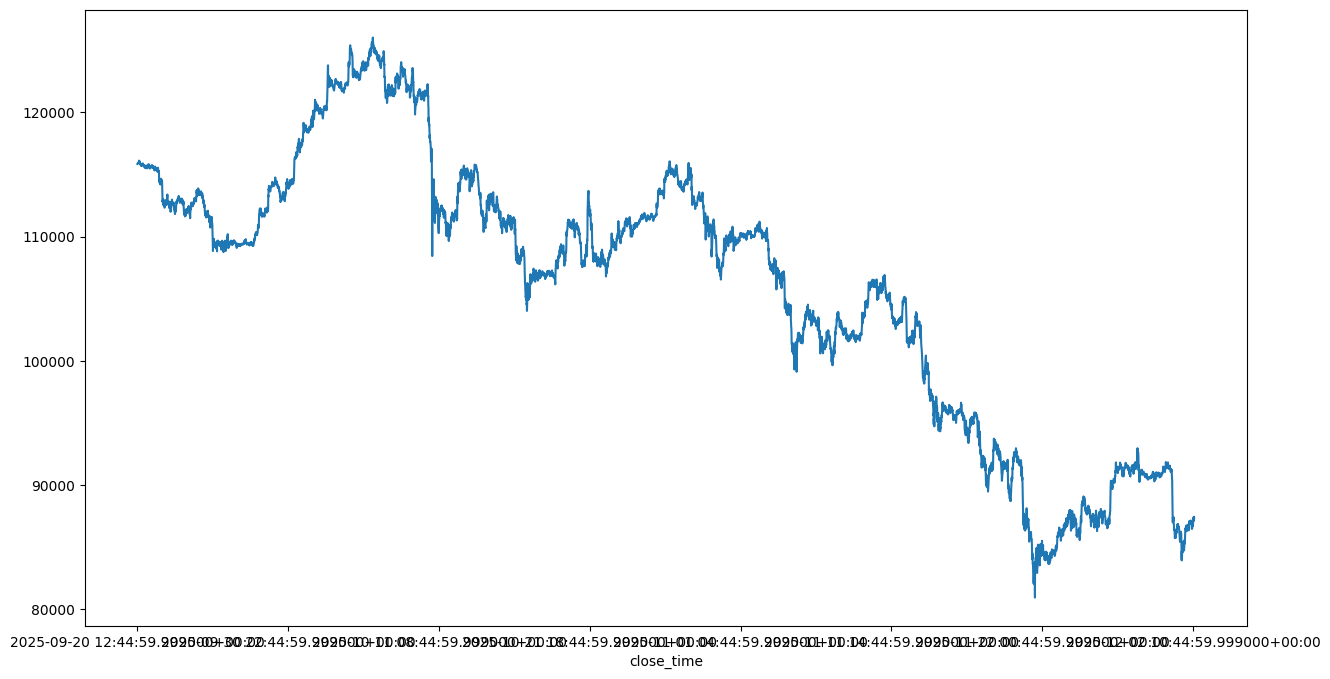

In [1375]:
df_test["close"].plot(figsize=(15, 8))

#### Display Equity curve

In [1376]:
intial_capital = 100

<Axes: xlabel='close_time'>

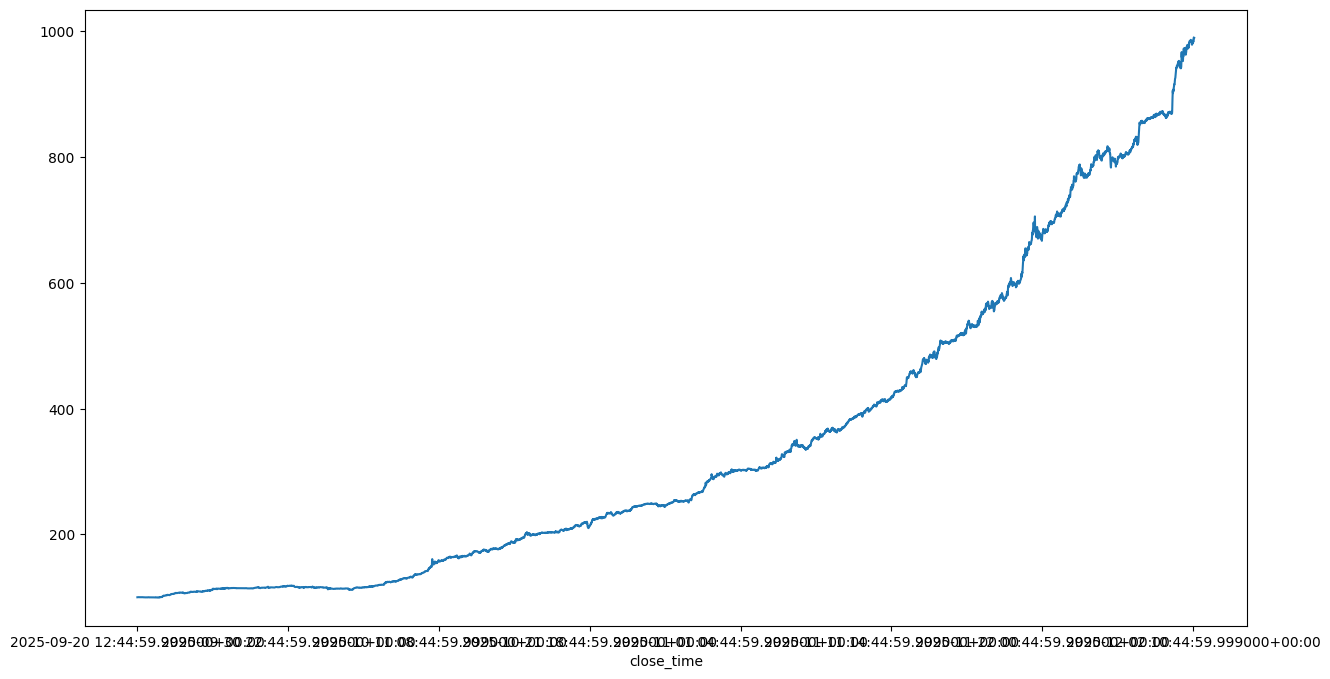

In [1377]:
df_test["trade_gross_pnl"] = np.exp(df_test["cum_trade_log_return"]) * intial_capital
df_test["trade_gross_pnl"].plot(figsize=(15, 8))

#### Individual Trade returns without compounding

<Axes: xlabel='close_time'>

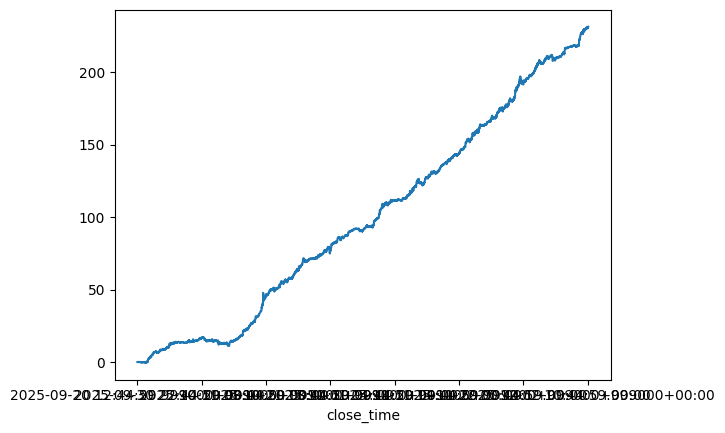

In [1378]:
# Convert log return to simple return for each trade
df_test["trade_simple_return"] = np.exp(df_test["trade_log_return"]) - 1

# PnL per trade = $100 * simple return
df_test["trade_pnl"] = 100 * df_test["trade_simple_return"]

# Cumulative PnL = sum of all individual trade PnLs
df_test["cumulative_pnl"] = df_test["trade_pnl"].cumsum()

df_test["cumulative_pnl"].plot()

#### Actual PNL after taking transaction fees into account

<Axes: xlabel='close_time'>

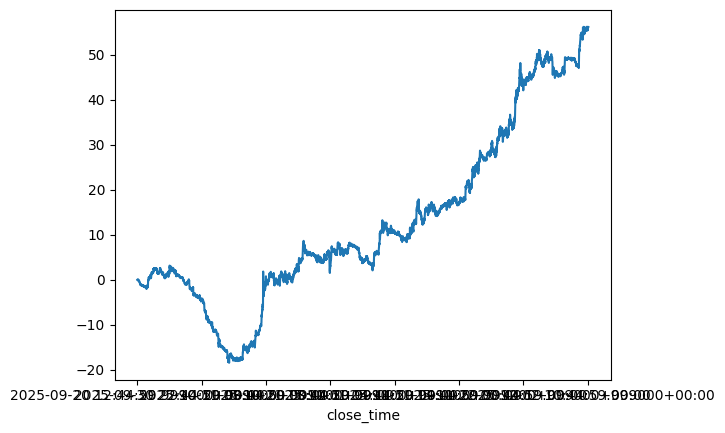

In [1379]:
# Step 1: Identify actual trades
df_test["signal_change"] = df_test["dir_signal"].diff().fillna(0)
df_test["is_trade"] = (df_test["signal_change"] != 0).astype(int)

# Step 2: Calculate returns
df_test["trade_simple_return"] = np.exp(df_test["trade_log_return"]) - 1

# Step 3: Apply cost ONLY on trades (0.075% = 0.00075 in decimal)
transaction_cost_pct = 0.00075
df_test["trade_cost"] = df_test["is_trade"] * transaction_cost_pct

# Step 4: Net return after cost
df_test["trade_simple_return_net"] = df_test["trade_simple_return"] - df_test["trade_cost"]

# Step 5: Calculate PnL
df_test["trade_pnl"] = 100 * df_test["trade_simple_return_net"]
df_test["cumulative_pnl"] = df_test["trade_pnl"].cumsum()

df_test["cumulative_pnl"].plot()

#### Evaluate total compound return

In [1380]:
total_compound_return = np.exp(df_test["trade_log_return"].sum())
total_compound_return

np.float64(9.897955220072973)

#### Evaluate Gross PnL

In [1381]:
total_compound_return * intial_capital

np.float64(989.7955220072972)

#### Total Percentage return without compounding

In [1382]:
total_return = df_test["trade_pnl"].sum() / 100
total_return_pct = total_return * 100
print(f"Total Return: {total_return_pct:.2f}%")

Total Return: 56.14%
